In [6]:
import os
import numpy as np
import torch
import time
import sys
import linecache
from torch.utils.data import DataLoader
from net import Net, NetMini, OtherNet, OtherNetMini
from dataset import Dataset
from testDataset import TestDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [12]:
with open(os.path.join(os.getcwd(), 'training_data', "1_output_hyper_params.csv"), 'r', newline="") as f:
    print('Model hyperparams')
    print(f.readline())
    print(f.readline())

Model hyperparams
batch_size,max_epochs,lr,decay,gamma

1024,20,0.1,0.001,0.5



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_type = 'one_class' # one_class, two_classes
# model_name = '1_output.pth' # <model_name>.pth

# model_type = 'one_class_mini'
# model_name = '1_output_mini.pth' # <model_name>.pth 

model_type = 'two_classes' 
model_name = '2_output.pth' # <model_name>.pth

# model_type = 'two_classes_mini' 
# model_name = '2_output_mini.pth' # <model_name>.pth

start_time = time.time()
if model_type == 'one_class':
    net = OtherNet().to(device)
elif model_type == 'one_class_mini':
    net = OtherNetMini().to(device)
elif model_type == 'two_classes':
    net = Net().to(device)
elif model_type == 'two_classes_mini':
    net = NetMini().to(device)
    
net.load_state_dict(torch.load(os.path.join(os.getcwd(), 'model', model_name), map_location=device))
net.eval()

print('Time to load the model:', time.time() - start_time, 'seconds')

Time to load the model: 0.6087801456451416 seconds


In [6]:
print(net)

OtherNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
 

In [8]:
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

activations = {}
for name, layer in net.named_children():
    layer.register_forward_hook(get_activation(name))

Test accuracy: 0.9856927710843374
Test F1 score: 0.9849802371541502
Testing Time: 8.833873987197876 seconds


<Axes: >

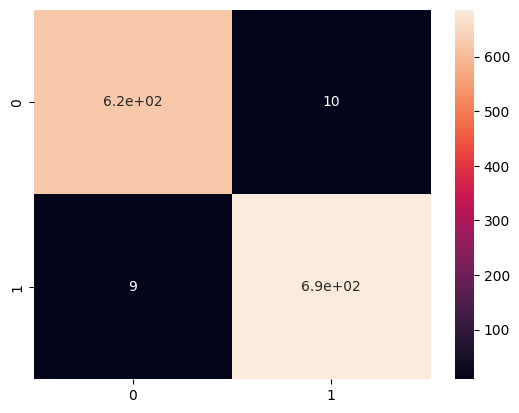

In [9]:
# Test full dataset

start_time = time.time()

test_data = Dataset(data_root=os.getcwd(), scaled=True, type='test', seed=42)
test_loader = DataLoader(dataset=test_data, batch_size=1024, num_workers=1, shuffle=False)

net.eval()
num_correct, num_total, TP, FP, FN = 0, 0, 0, 0, 0

with torch.no_grad():
    for inputs in test_loader:
        if model_type == 'one_class' or model_type == 'one_class_mini':
            images = inputs[1].to(device).float()
            labels = inputs[0].to(device).float().view(-1, 1)
        elif model_type == 'two_classes' or model_type == 'two_classes_mini':
            images = inputs[1].to(device)
            labels = inputs[0].to(device).float()
            images = images.float()

        outputs = net(images)
        
        if model_type == 'one_class' or model_type == 'one_class_mini':
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).float()
        elif model_type == 'two_classes' or model_type == 'two_classes_mini':
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            
        num_correct += (preds == labels).sum().item()
        num_total += labels.size(0)
        TP += ((preds == 1) & (labels == 1)).sum().item()
        FP += ((preds == 1) & (labels == 0)).sum().item()
        FN += ((preds == 0) & (labels == 1)).sum().item()


acc = num_correct / num_total
print('Test accuracy: ' + str(acc))
f1_score = 2 * TP / (2 * TP + FP + FN)
print('Test F1 score:', f1_score)

print('Testing Time: ' + str(time.time() - start_time) + ' seconds')

#use tp, fp, fn to plot confusion matrix
cm = [[TP, FP], [FN, (num_total - TP - FP - FN)]]
sns.heatmap(cm, annot=True)

Output probabilities: tensor([[0.7957, 0.2043]])
Ground truth: 0.0, Predicted label: 0
Prediction matches Ground truth: True


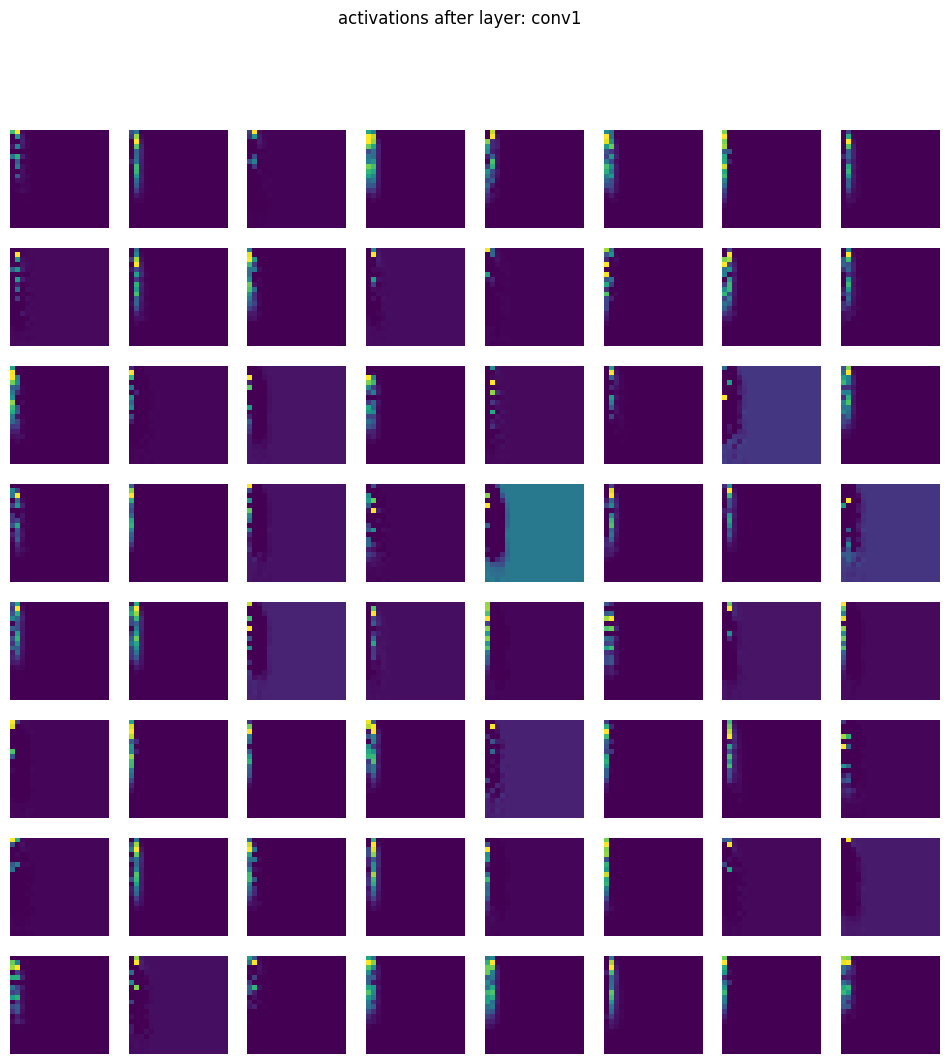

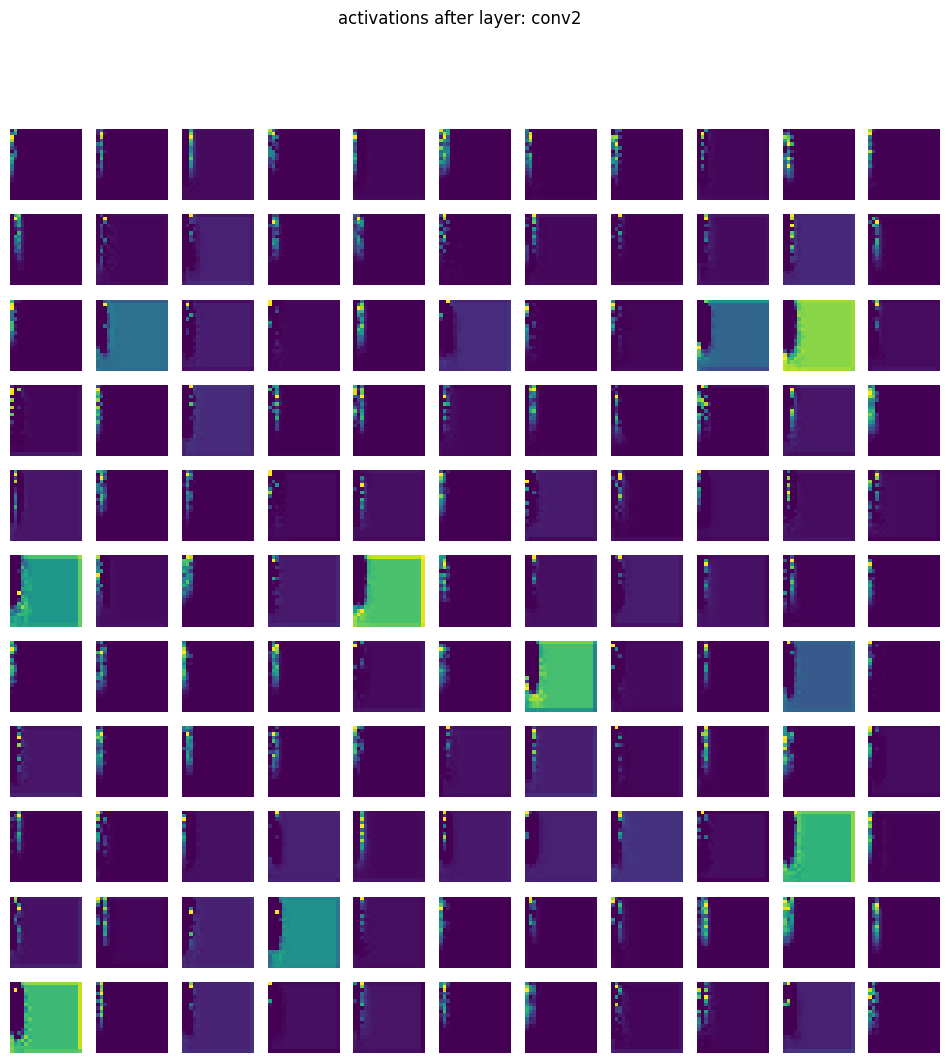

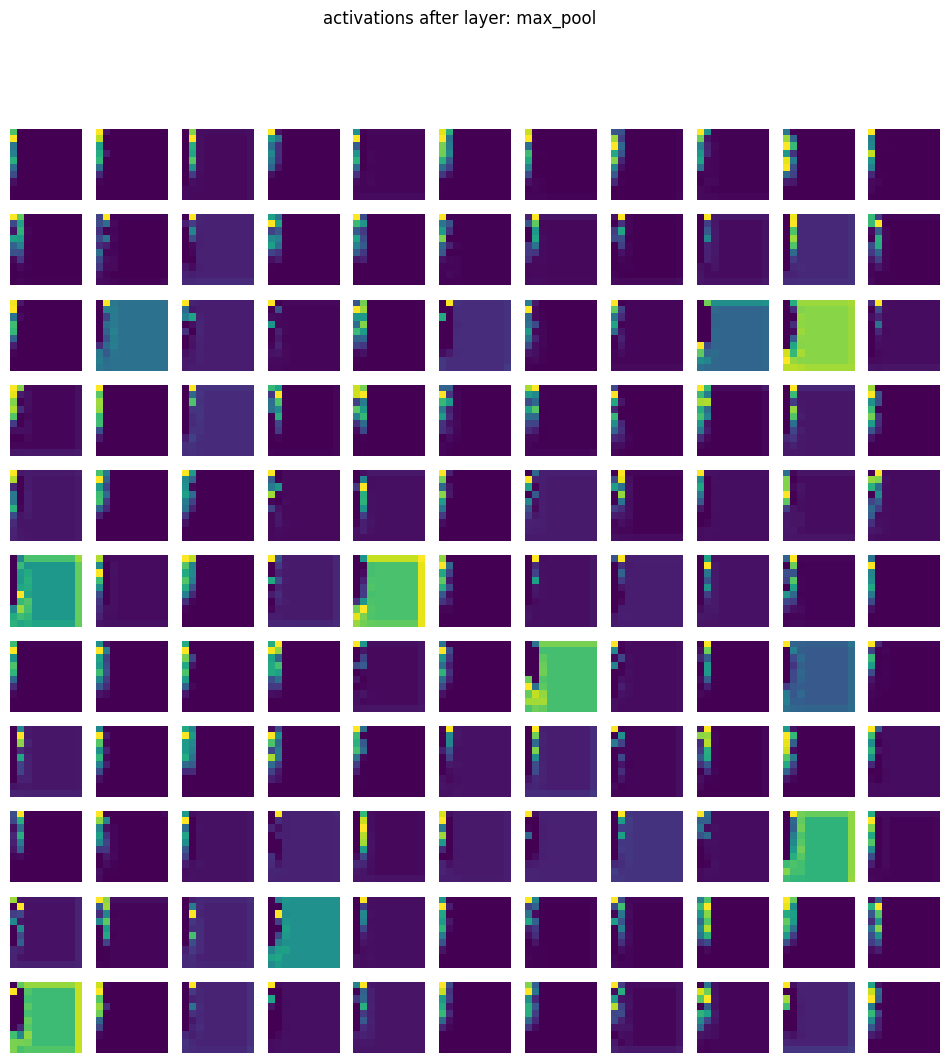

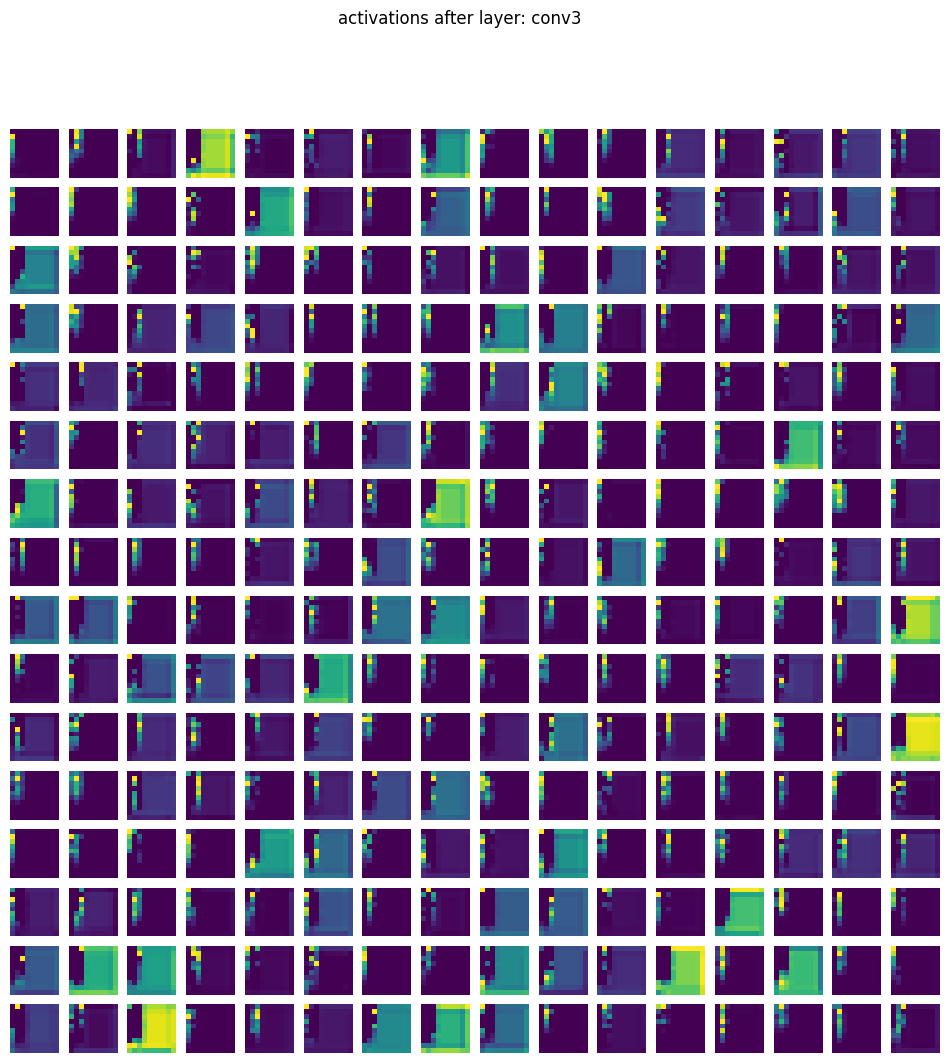

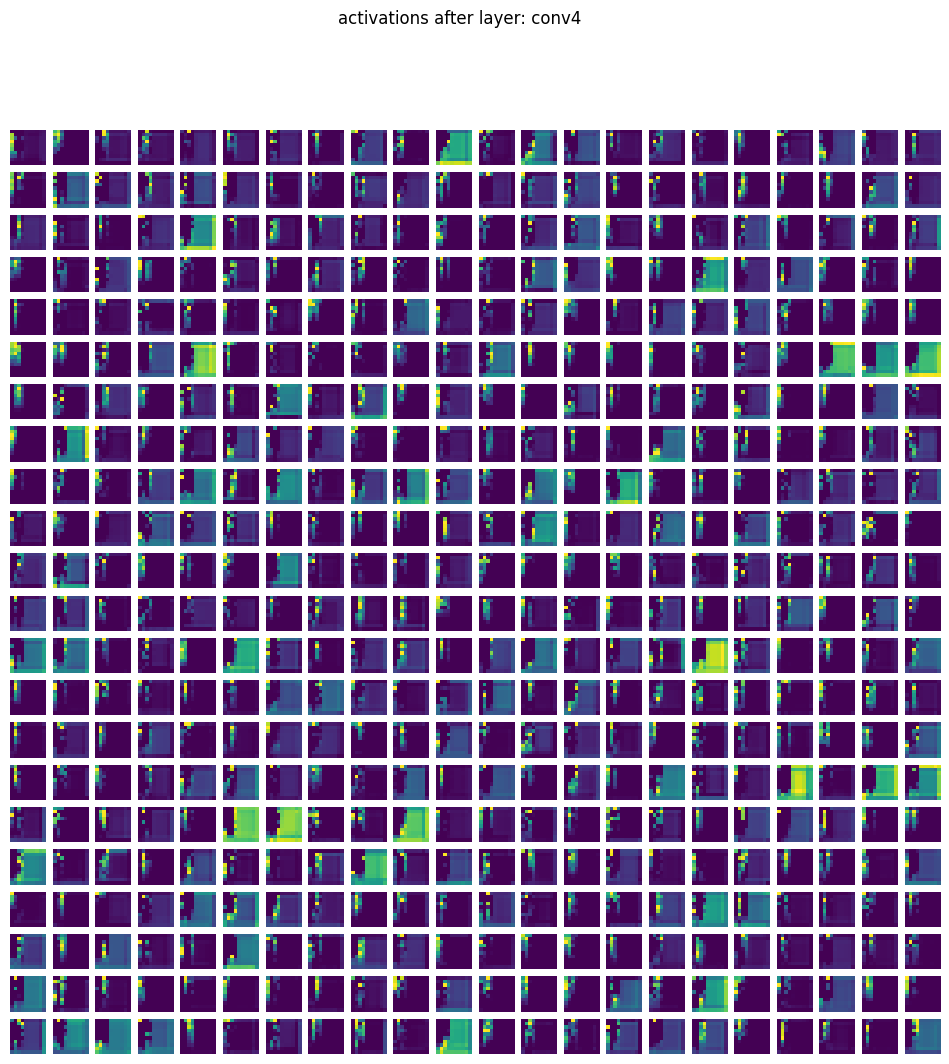

In [12]:
# Test single image
index = 42
data = TestDataset(data_root=os.getcwd(), index=index, scaled=True, type='test')
loader = DataLoader(dataset=data, batch_size=1, num_workers=1, shuffle=False)
with torch.no_grad():
    for inputs in loader:
        if model_type == 'one_class' or model_type == 'one_class_mini':
            images = inputs[1].to(device).float()
            labels = inputs[0].to(device).float().view(-1, 1)
        elif model_type == 'two_classes' or model_type == 'two_classes_mini':
            images = inputs[1].to(device)
            labels = inputs[0].to(device).float()
            images = images.float()

        outputs = net(images)
        
        if model_type == 'one_class' or model_type == 'one_class_mini':
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).float()
        elif model_type == 'two_classes' or model_type == 'two_classes_mini':
            # values, preds = torch.max(outputs.detach(), dim=1)
            probabilities = torch.softmax(outputs, dim=1)
            print("Output probabilities:", probabilities)
            preds = torch.argmax(probabilities, dim=1)
            
        print('Ground truth: ' + str(labels.item()) + ', Predicted label: '+ str(preds.item()))
        print('Prediction matches Ground truth: ' + str(preds.item() == labels.item()))

# Plot
for name, activation in activations.items():
    if name != 'fc1' and name != 'fc2':
        num_features = activation.shape[1]
        
        size = int(num_features ** 0.5)
        
        fig, axes = plt.subplots(size, size, figsize=(12, 12))   
        for i, ax in enumerate(axes.flat):
            if i < num_features:
                ax.imshow(activation[0, i].cpu().numpy(), cmap='viridis')
            ax.axis('off')
        
        plt.suptitle(f'activations after layer: {name}')
        plt.show()